# <center> Reconnaissance visuelle 

### 1. Préparation du dataset pour vision

On choisit d'utiliser le dataset avec les transformations pertinentes appliquées après exploration des données. Notamment 4 styles avec un nombre insuffisant d'image ont été supprimés pour avoir des classes équilibrées lors de l'apprentissage dans la partie Deep Learning.

In [5]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))
DATA_ROOT = PROJECT_ROOT/"data"

import src.dataset as dataset_module
import src.preprocessing as preprocessing_module
import src.vision_features_extract as vision_features_extract_module

from importlib import reload

vision_features_extract_module = reload(vision_features_extract_module)

df_test, df_train, df_val = dataset_module.load_df_train_test_val(DATA_ROOT)
df = dataset_module.load_df(DATA_ROOT)

df, df_test, df_train, df_val = preprocessing_module.clean_dataset(df, df_train, df_val, df_test)

print(f"Vérification des splits :")
print(f"- Train: {df_train['split'].unique()} ({len(df_train)} images)")
print(f"- Val  : {df_val['split'].unique()} ({len(df_val)} images)")
print(f"- Test : {df_test['split'].unique()} ({len(df_test)} images)")

#correction
df_test, df_train, df_val = dataset_module.load_df_train_test_val(DATA_ROOT)

df_full = dataset_module.load_df(DATA_ROOT)
df, df_train, df_val, df_test = preprocessing_module.clean_dataset(
    df_full, df_train, df_val, df_test
)

df, df_train, df_val, df_test = preprocessing_module.clean_dataset(df, df_train, df_val, df_test)

print(f"Vérification des bons splits :")
print(f"- Train: {df_train['split'].unique()} ({len(df_train)} images)")
print(f"- Val  : {df_val['split'].unique()} ({len(df_val)} images)")
print(f"- Test : {df_test['split'].unique()} ({len(df_test)} images)")

Vérification des splits :
- Train: <StringArray>
['val']
Length: 1, dtype: str (1373 images)
- Val  : <StringArray>
['test']
Length: 1, dtype: str (1378 images)
- Test : <StringArray>
['train']
Length: 1, dtype: str (6449 images)
Vérification des bons splits :
- Train: <StringArray>
['train']
Length: 1, dtype: str (6449 images)
- Val  : <StringArray>
['val']
Length: 1, dtype: str (1373 images)
- Test : <StringArray>
['test']
Length: 1, dtype: str (1378 images)


### 2. Extraction des features



#### 2.1 Contour et gradients 



Dans cette section, nous étudions les contours présents dans les œuvres du dataset WikiArt.
L’objectif est de déterminer si certains styles artistiques se distinguent par des contours
plus nets ou plus flous, à l’aide d’un détecteur de Sobel et d’analyses statistiques des gradients.

L'intuition serait que les styles nets (Cubisme, Pop Art, Precisionism) auraient des gradients forts, orientations bien définies, forte magnitude tandis que les styles flous (Impressionism, Romanticism, Baroque) auraient des gradients plus faibles, orientations dispersées, faible magnitude.

##### 2.1.1 Sous Dataset

Nous sélectionnons quelques styles contrastés afin de faciliter l’analyse qualitative
et quantitative des contours.


In [2]:
selected_styles = ["Impressionism", "Cubism", "Baroque", "Romanticism", "Pop_Art"]

df_subset = df[df["style_name"].isin(selected_styles)]
print(df_subset["style_name"].value_counts())


style_name
Pop_Art          400
Cubism           400
Impressionism    400
Baroque          400
Romanticism      400
Name: count, dtype: int64


##### 2.1.2 Sobel

In [ ]:
vision_features_extract_module.plot_sobel_examples(
    df_subset,
    dataset_module.load_image,
    styles=selected_styles,
    n_images_per_style=3
)


TypeError: load_image() missing 1 required positional argument: 'DATA_DIR'

Error in callback <function flush_figures at 0x0000025D4761B560> (for post_execute), with arguments args (),kwargs {}:


On observe que certains styles présentent des contours plus nets et structurés
(PopArt, Cubism), tandis que d’autres styles comme l’Impressionnisme montrent
des transitions plus douces et moins de contours marqués.


##### 2.1.3 Extraction des histogrammes de gradient

Nous calculons maintenant, pour chaque image, des histogrammes de magnitude
et d’orientation des gradients afin de quantifier la structure des contours.


In [ ]:
style_gradients = vision_features_extract_module.aggregate_histograms_by_style(
    df,
    dataset_module.load_image,
    max_images_per_style=150
)


  0%|          | 0/9200 [00:00<?, ?it/s]

100%|██████████| 9200/9200 [23:37:19<00:00,  9.24s/it]         


##### 2.1.4 Histogrammes moyens par styles

On affiche les histogrammes moyens par style de magnitude puis d'orientation :

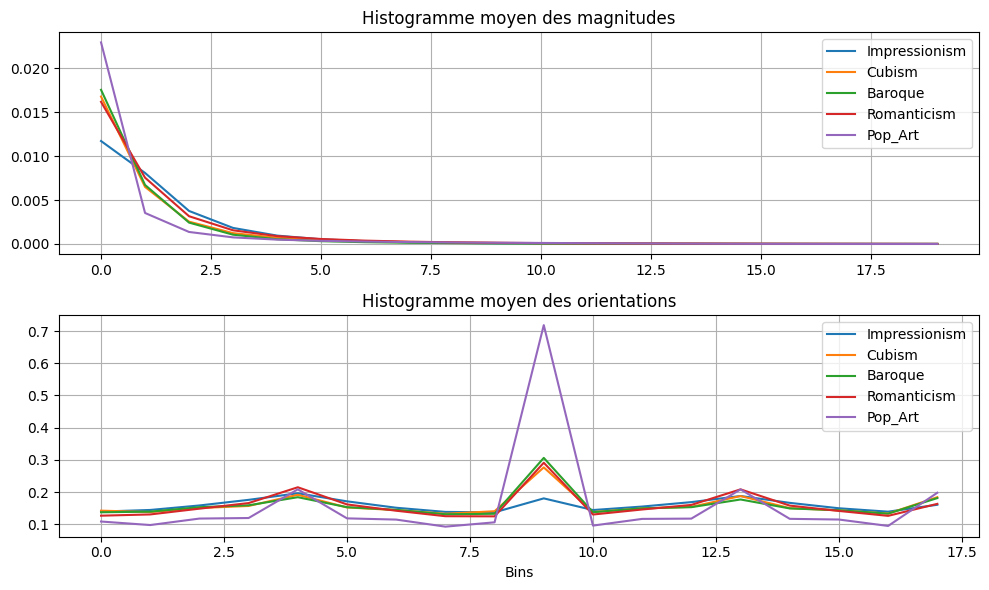

In [ ]:
vision_features_extract_module.plot_mean_gradient_histograms(
    style_gradients,
    selected_styles,
)


On observe seulement pour Pop Art une démarcation dans l'histogramme des orientations du gradient. Le reste des styles ne sont pas particulièrement reconnaissables via cette information. Ce n'est pas suffisant.

On va essayer de claculer un score par style pour determiner si c'est uns tyle aux contour fort ou fiable

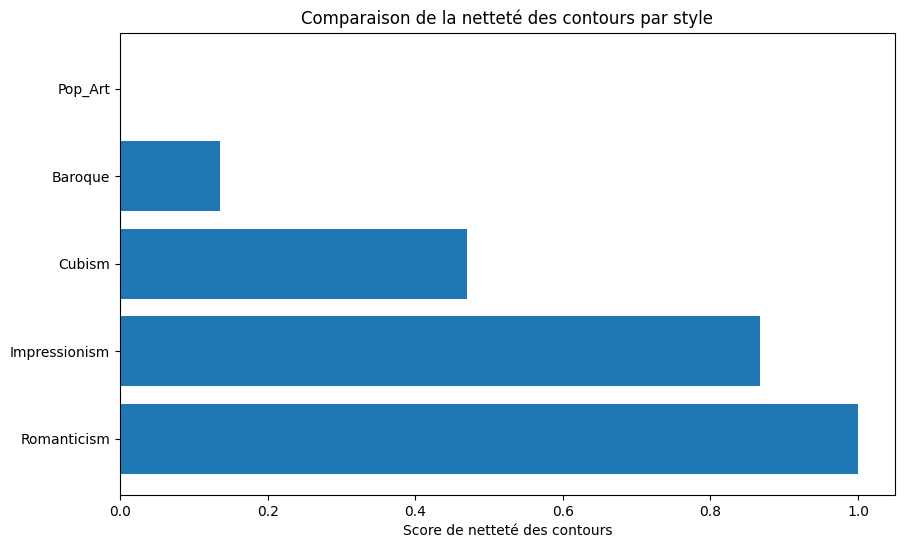

In [ ]:
vision_features_extract_module.compute_scores(selected_styles, style_gradients)

Impressionnisme = score élevé : beaucoup de coups de pinceau, gradients forts, mais diffus spatialement

Pop Art = score faible : aplats de couleur, grandes zones uniformes, peu de gradient

L’analyse des gradients de Sobel montre que les styles artistiques se
distinguent nettement par l’intensité moyenne de leurs transitions
locales.
Certains styles, comme l’impressionnisme ou l’expressionnisme,
présentent une forte proportion de gradients élevés, traduisant une
richesse de variations locales et de coups de pinceau visibles.
À l’inverse, des styles comme le Pop Art ou le Minimalisme reposent
davantage sur de larges aplats de couleur, générant moins de gradients
de forte amplitude.

#### 2.2 Descripteurs globaux

Nous utiliserons des descripteurs globaux pour
compl´eter nos features. Nous utiliserons le descripteur
HOG qui capturera la structure directionnelle locale (tech-
nique picturale) ainsi qu’un descripteur couleur dans les
espaces.


Pour chaque image on extrait HOG : Histogram of Oriented Gradient.
Puis on extrait des descripteurs de couleur dans les espaces Lab et HSV. 
Enfin on normalise et combine toutes ses features en un vecteur par image. 

In [ ]:
x, y = vision_features_extract_module.extract_features_dataset(df_subset, dataset_module.load_image)

100%|██████████| 2000/2000 [13:47<00:00,  2.42it/s]


Nombre d'images : 2000
Dimension du vecteur de features : 14276


On observe les résultats : 
D'abord en observant quels styles sont visuellement proches avec HOG + couleurs, et ensuite en observant le rendu PCA.

In [ ]:
dist_df = vision_features_extract_module.visualize_style_distances(x,y)

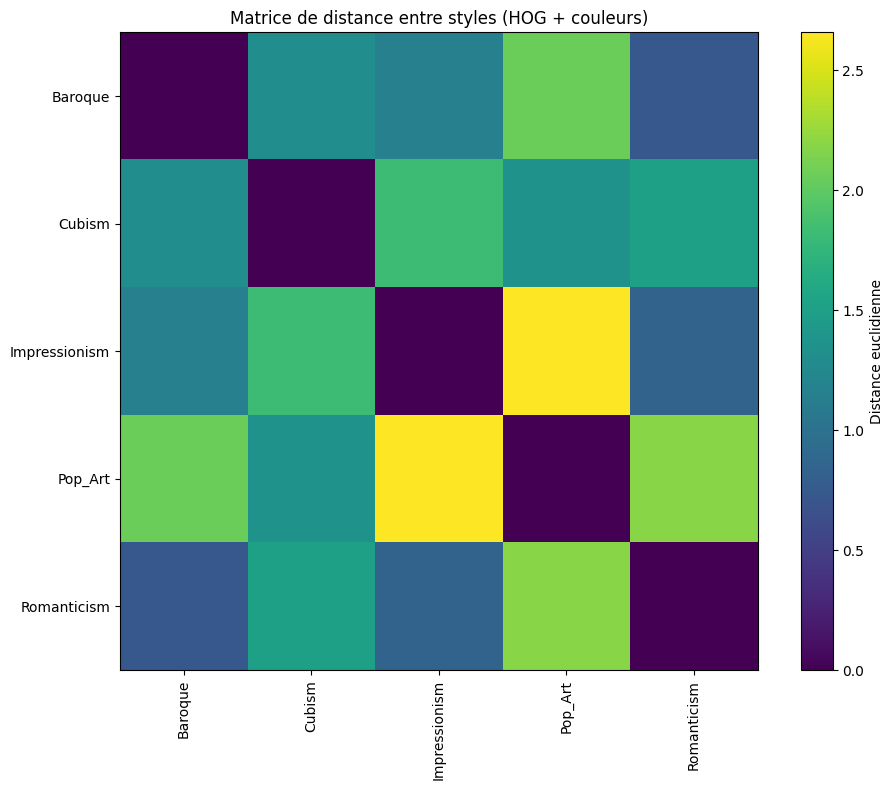

In [ ]:
vision_features_extract_module.heatmap_style_distances(dist_df)
# intéressant de comparer cette matrice a celle des distances avec les genres 

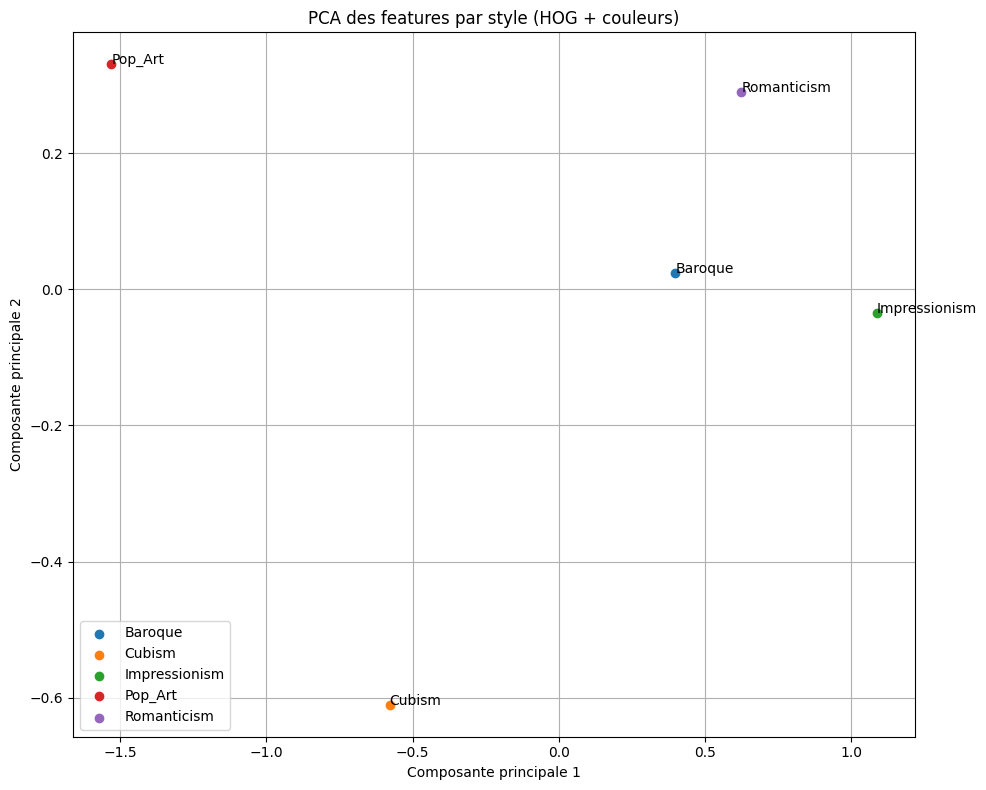

: 

In [ ]:
vision_features_extract_module.pca_style_features(x,y)

# todolist

## 2. Extraction de features
### 2.1. Contours et gradients
- [ ] Appliquer **détecteur de Sobel** sur chaque image DONE 
- [ ] Calculer histogrammes pour chaque image :DONE
  - Magnitude des gradients
  - Orientation des gradients
- [ ] Vérifier que les histogrammes différencient bien styles nets vs flous. BOF

### 2.2. Descripteurs globaux
- [ ] Extraire **HOG** (Histogram of Oriented Gradients) pour chaque image. DONE
- [ ] Extraire descripteurs de couleur dans les espaces **Lab** et **HSV**. DONE
- [ ] Normaliser et combiner toutes les features en un seul vecteur par image. DONE
- [ ] Créer une fonction `extract_features(image)` réutilisable.  DONE
- Avoir un bilan "palette de couleur" par styles  #TODO
 
## 3. Classification SVM
- [ ] Séparer features en train / val / test. DONE
- [ ] Normaliser / standardiser les features. + combiner tout les descripteurs precedents
- [ ] Entraîner un **SVM avec noyau RBF** sur le train.
- [ ] Évaluer le modèle sur val et test :
  - Précision globale
  - F1-score par style
  - Matrices de confusion détaillées
- [ ] Identifier les confusions fréquentes et vérifier si elles correspondent à des confusions humaines.
- [ ] Identifier les features les plus discriminantes pour chaque style.

## 4. Analyse et visualisation
- [ ] Visualiser quelques images par style pour valider les features.
- [ ] Histogrammes :
  - Nombre d’images par style
  - Distribution des artistes par style (exclure “unknown”)
  - Distribution des genres par style (exclure “unknown”)
- [ ] Analyse qualitative des styles avec images non “peinture” (statues, architecture…).
- [ ] Étudier la proportion d’artistes communs entre splits et risques de fuite.
- [ ] Visualiser relations artistes ↔ styles et genres ↔ styles.
- [ ] Préparer graphiques clairs pour le rapport (histogrammes, exemples d’images).

## 5. Validation causale par ablation (facultatif / si FFT fait par l’autre personne)
- [ ] Créer versions du dataset :
  - Original
  - Passe-haut
  - Passe-bas
- [ ] Entraîner un ResNet18 pour chaque version.
- [ ] Comparer performances pour confirmer l’importance des signatures fréquentielles.

## Notes
- Toutes les fonctions d’extraction doivent être centralisées dans `src/dataset.py`.
- Préparer les notebooks pour visualisation et tests rapides sans écraser les fichiers originaux.
